In [1]:
# -*- coding: utf-8 -*-
#import esda
import os
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
#import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
#import contextily as ctx
from pylab import figure, scatter, show
import warnings
# warnings.filterwarnings('ignore')
# %matplotlib inline

In [2]:
def find_name(point):
    for name, polygon in zip(df_map['NAME'], df_map['geometry']):
        if point.within(polygon):
            return name
    return ''

In [3]:
# read the map information of London
df_map = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI', crs='ESRI:54004')

# read all osm poi data and get their fclass for poi classification
poi_filenames = ['140101','150101','160101','170101','180101','190101','200101',
                 '210101','220101','latest',] #latest represents for 01.26,2023
years = ['2014','2015','2016','2017','2018','2019','2020',
                 '2021','2022','2023',] #latest represents for 2023

# get all fclass during 2014-2023. 
# There are 134 fclasses, checking it in the file ../data/fclass_to_poi-class.xlsx
fclass=np.array([])
for i in range(len(poi_filenames)):
    scattergdf = gpd.read_file(
        f'../data/osm_poi_data/greater-london-{poi_filenames[i]}-free.shp/gis_osm_pois_free_1.shp')
    #write fclass to xlsx for classification
    temp = scattergdf['fclass'].unique()
    fclass = np.union1d(fclass,temp)
temp = pd.DataFrame(fclass)
temp.to_excel('../data/fclass_to_poi-class.xlsx')

In [4]:
temp

,0
0,archaeological
1,arts_centre
2,artwork
3,atm
4,attraction
...,...
129,water_well
130,water_works
131,wayside_shrine
132,windmill


In [9]:
# achieve the selected poi xlsx and shp data during 2014-2023

# df_map = df_map.to_crs(epsg=4326)
# There are two types of classification, eight classes in china ../data/fclass_to_poi-class.xlsx，
poi_class = pd.read_excel('../data/fclass_to_poi-class.xlsx', 
                          usecols=['fclass from osm','poi class'])
poi_class = poi_class[poi_class['poi class']>0]
poi_class

,fclass from osm,poi class
5,bakery,2.0
9,beauty_shop,3.0
12,beverages,2.0
14,bicycle_shop,6.0
16,bookshop,4.0
17,butcher,2.0
18,cafe,2.0
21,car_dealership,6.0
28,chemist,5.0
30,clinic,5.0


In [6]:
numbers = []
for i in range(len(poi_filenames)):
    scattergdf = gpd.read_file(
        f'../data/osm_poi_data/greater-london-{poi_filenames[i]}-free.shp/gis_osm_pois_free_1.shp')
    
    outdir = f'../result/data/osm_poi_data_selected/{years[i]}/'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # merge the poi class to the osm shp file
    scattergdf = pd.merge(scattergdf, poi_class, left_on='fclass', right_on = 'fclass from osm',
                          how='inner')
    scattergdf = scattergdf.drop(labels = 'fclass from osm',axis = 1)
    scattergdf.rename(columns={'poi 分类':'class'},inplace=True)
    scattergdf.to_file(outdir+f'greater-london-{years[i]}-free-selected.shp',
           driver='ESRI Shapefile',
           encoding='utf-8')
    
    scattergdf_new = gpd.read_file(outdir+
        f'greater-london-{years[i]}-free-selected.shp')
    
    
    # get the poi csv with poi class index
    scattergdf_new['borough'] = scattergdf_new['geometry'].apply(find_name)
    scattergdf_new[['osm_id','code','fclass','name','class', 'borough']].to_excel(
        outdir+f'poi_{years[i]}.xlsx')
    
    # Extracting the number of poi categories per year
    temp = scattergdf_new['class'].value_counts()
    temp = pd.DataFrame(temp)
    temp.rename(columns={'class':f'{years[i]}_numbers'},inplace=True)
    temp['class'] = temp.index
    temp[f'{years[i]}_percent(%)'] = temp[f'{years[i]}_numbers'].values/temp[f'{years[i]}_numbers'].values.sum()*100
    temp.sort_values(by='class',ascending=True,inplace=True)
    numbers.append(temp)

numbers_merge = pd.merge(numbers[0],numbers[1],on='class')
for i in  numbers[2:]:
    numbers_merge = pd.merge(numbers_merge,i,on='class')

# Adjusting the column order of class
c = numbers_merge.pop('class')
numbers_merge.insert(0,'class',c)
numbers_merge.loc['sum']=numbers_merge.apply(lambda x: x.sum())
numbers_merge.iloc[8,0] = 'total'

numbers_merge.to_csv('../result/data/poi_numbers.csv',index=False)

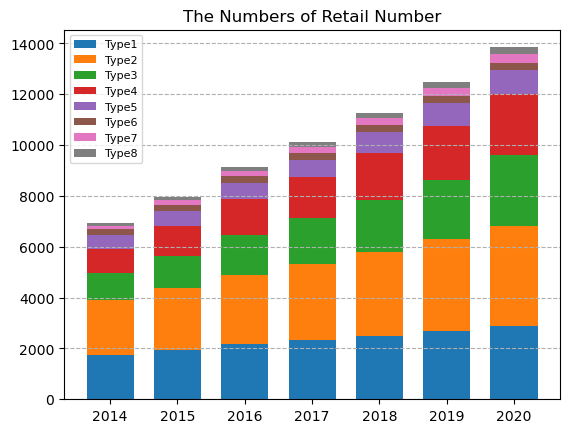

In [8]:
# plot the yearly retail numbers for different type
# read all osm poi data and get their fclass for poi classification
poi_filenames = ['140101','150101','160101','170101','180101','190101','200101',
                 '210101','220101','latest',] #latest represents for 01.26,2023
years = ['2014','2015','2016','2017','2018','2019','2020',
                 '2021','2022','2023',] #latest represents for 2023
years_n = list(range(2014,2021))

data = pd.read_csv('../result/data/poi_numbers.csv')
labels = ['1','2','3','4','5','6','7','8']
#nT = int(scattergdf['class'].max())

fig, ax = plt.subplots()
width = 0.7

xx=years[:7]
cols = data.columns[1:15:2]
data = data[cols]
#cl = data['class'].values[:-1]
y = list(data.loc[0])
ax.bar(xx, y, width,label='Type'+labels[0])
sumy = y
#print(y)

for ii,i in enumerate(labels[1:]):
    y = list(data.loc[ii+1])
    #print(y)
    ax.bar(xx, y, width, bottom=sumy,label='Type'+i)
    sumy=[sumy[j]+y[j] for j in range(len(y))]

ax.grid(axis='y',linestyle='--')
ax.legend(loc='upper left',fontsize=8,ncol=1)
ax.set_title("The Numbers of Retail Number")

path_out = '../result/plot/'
filename = 'yearly_retail_numbers'
plt.savefig(path_out+filename+'.png',
            dpi=500,bbox_inches = 'tight')